In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
torch.cuda.device_count()

1

In [2]:
import transformers    

model = transformers.AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    use_auth_token=True,
    device_map="auto",
    offload_folder="./offload",
    attn_implementation="eager"
)

tokenizer = transformers.AutoTokenizer.from_pretrained("google/gemma-2-2b")
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

from models.gemma_2 import Gemma

hooked_model = Gemma(model, tokenizer)


/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


In [3]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
correct = 0
sum_logit_diff = 0
with torch.no_grad():
    for iter, batch in tqdm(enumerate(dataloader)):
        batch_tokens = batch["tokens"].cuda()
        
        logits = hooked_model.model(batch_tokens).logits.cpu()
        correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
        incorrect_logits = [
                [
                    tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                ]
                for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
            ]
        incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
        max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
        logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
        
        correct += (np.array(logit_diff) > 0).sum()
        sum_logit_diff += (np.array(logit_diff)).sum()
correct / len(tokenized_dataset), sum_logit_diff / len(tokenized_dataset)

204it [00:51,  3.97it/s]


(0.2181372549019608, -2.6277652125732573)

In [36]:
task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)

random_choice = 0
for item in tokenized_dataset:
    random_choice += 1 / item["num_labels"].item()
print(random_choice / len(tokenized_dataset))

0.22191125187448765


In [4]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)

Map: 100%|██████████| 818/818 [00:00<00:00, 1250.76 examples/s]


In [6]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch

accuracies = []
correct_activations = {(layer, head) : []
                       for layer in range(len(hooked_model.model.model.layers))
                       for head in range(hooked_model.model.model.layers[0].self_attn.num_heads)}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"].cuda()
        hooked_model.model(batch_tokens)

        for layer in range(len(hooked_model.model.model.layers)):
            for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
                correct_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                    np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                    ].detach().cpu())

for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        correct_activations_dataset = torch.vstack(correct_activations[(layer, head)])
        X = correct_activations_dataset.numpy()
        y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

100%|██████████| 409/409 [00:27<00:00, 14.65it/s]


In [7]:
accuracies_sorted = []
i = 0
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accuracies_sorted.append((-accuracies[i], layer, head))
        i += 1
accuracies_sorted = sorted(accuracies_sorted)

In [3]:
import json
# with open("cache/accuracies_sorted_gemma.json", "w") as file:
#     json.dump(accuracies_sorted, file)
with open("cache/accuracies_sorted_gemma.json", "r") as file:
    accuracies_sorted = json.load(file)

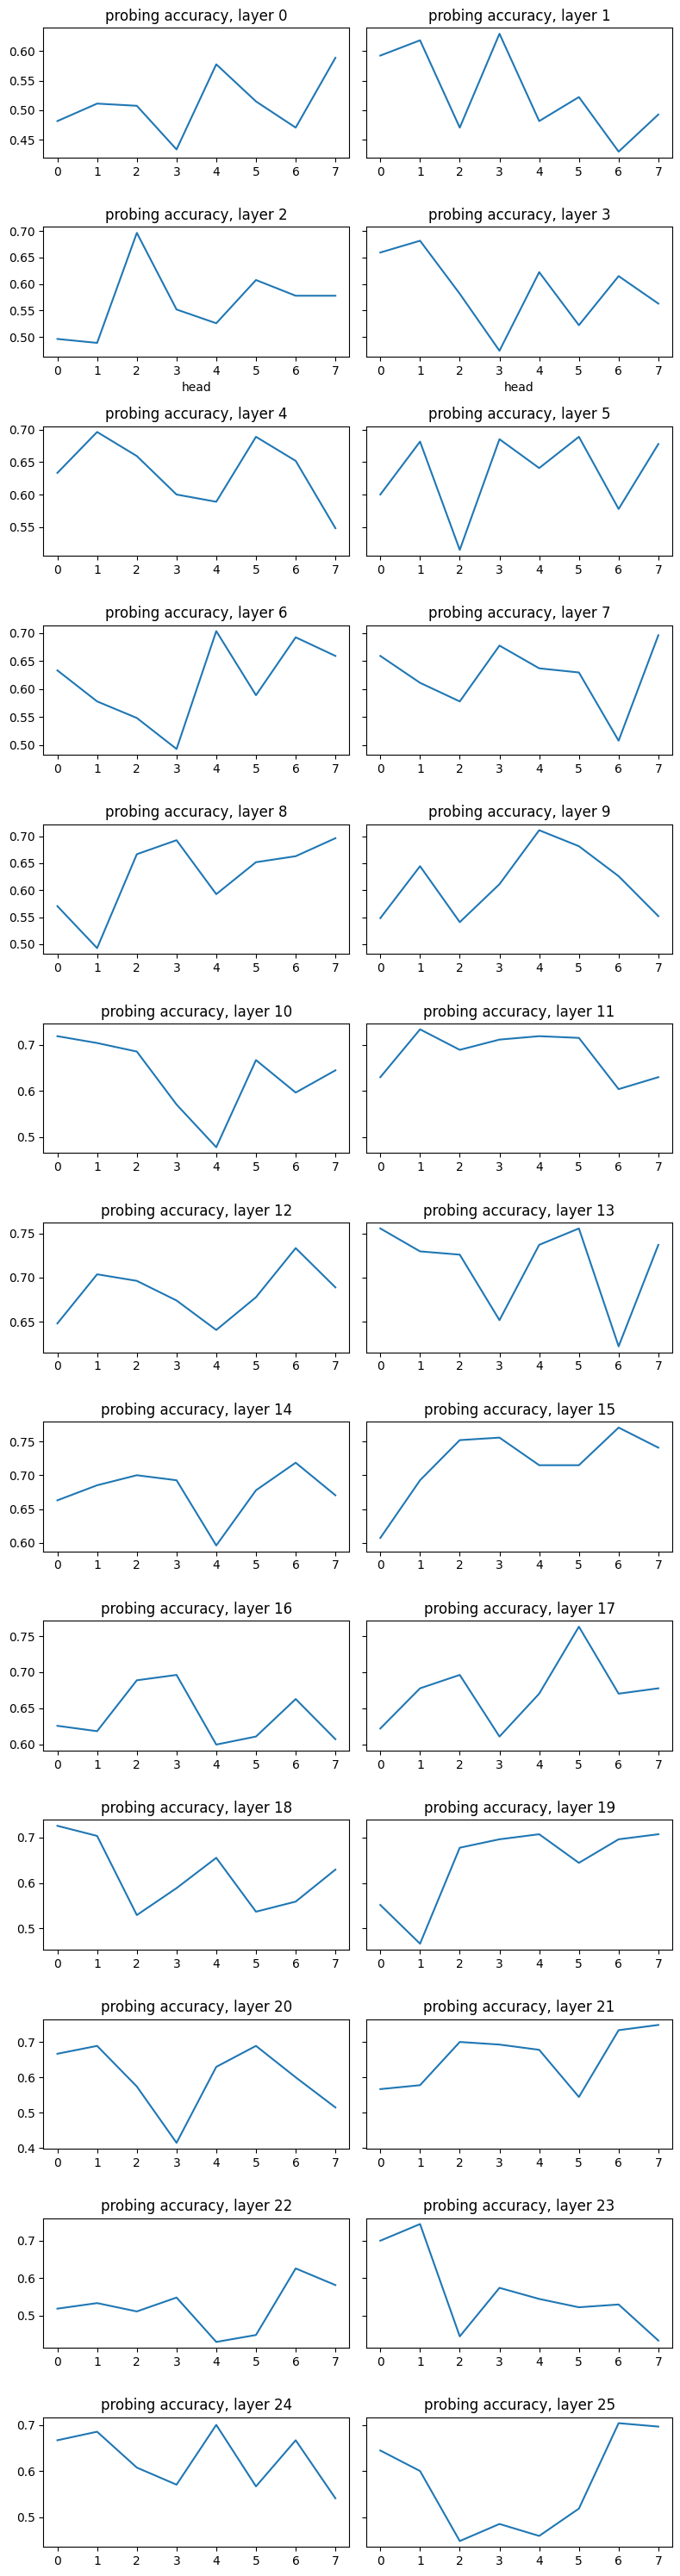

In [17]:
import matplotlib.pyplot as plt
from collections import defaultdict
i = 0
accs_by_layer = defaultdict(list)
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accs_by_layer[layer].append(accuracies[i])
        i += 1
        
fig, axs = plt.subplots(13, 2, sharey="row")
fig.set_size_inches((8, 30))
for i, layer in enumerate(accs_by_layer):
    y = i // 2
    x = i % 2
    axs[y][x].plot(accs_by_layer[layer])
    axs[y][x].set_title(f"probing accuracy, layer {layer}")

for i in range(13):
    for j in range(2):
        axs[i][j].set_xticks(np.arange(len(accs_by_layer[0])), labels=np.arange(len(accs_by_layer[0])))
        if i == 1:
            axs[i][j].set_xlabel("head")
fig.tight_layout()
plt.savefig("images/probing_accuracies_gemma.png")

In [12]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)


steering_directions = {(layer, head): None for layer in range(26) for head in range(8)}
stds = {(layer, head): None for layer in range(26) for head in range(8)}

all_activations = {pos : [] for pos in steering_directions.keys()}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"].cuda()
        hooked_model.model(batch_tokens)

        for layer, head in steering_directions.keys():
            all_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                ].detach().cpu())

for layer, head in steering_directions.keys():
    all_activations_dataset = torch.vstack(all_activations[(layer, head)])
    X = all_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
    pos_activations = X[y == 1]
    neg_activations = X[y == -1]
    steering_directions[(layer, head)] = np.mean(pos_activations, axis=0) - np.mean(neg_activations, axis=0)
    direction_norm = np.linalg.norm(steering_directions[(layer, head)])
    stds[(layer, head)] = np.std(np.dot(X, steering_directions[(layer, head)]) / direction_norm)

100%|██████████| 409/409 [00:31<00:00, 13.15it/s]


In [15]:
import json
# with open("cache/steering_directions_gemma.json", "w") as file:
#     json.dump({str(item): steering_directions[item].tolist() for item in steering_directions}, file)
# with open("cache/stds_gemma.json", "w") as file:
#     json.dump({str(item): stds[item].item() for item in stds}, file)
import numpy as np
import json
with open("cache/steering_directions_gemma.json", "r") as file:
    steering_directions_json = json.load(file)
steering_directions = {}
for item in steering_directions_json:
    steering_directions[eval(item)] = np.array(steering_directions_json[item])
with open("cache/stds_gemma.json", "r") as file:
    stds_json = json.load(file)
stds = {}
for item in stds_json:
    stds[eval(item)] = stds_json[item]

In [28]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
from collections import defaultdict

ks = [4, 8, 12, 16]# [64, 80, 96]
alphas = [1, 5, 10, 15]# [0, 20, 25, 30]

task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_datasets = []
for seed in [42, 0, 5, 10, 15]:
    tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=True, testing_split=False,
                                                random_seed=seed, subset_len=81, max_length=1000)
    tokenized_datasets.append(tokenized_dataset)

# accs_by_k_alpha = defaultdict(list)
# logit_diffs_by_k_alpha = defaultdict(list)
for k in ks:
    for alpha in alphas:
        for dataset_i in range(len(tokenized_datasets)):
            dataloader = DataLoader(tokenized_datasets[dataset_i], batch_size=2, shuffle=False)
            correct = 0
            sum_logit_diff = 0
            positions_to_steer = [(t[1], t[2], -1) for t in accuracies_sorted[:k]]
            vectors = [alpha * steering_directions[(pos[0], pos[1])] * stds[(pos[0], pos[1])] for pos in positions_to_steer]
            hooked_model.set_steering_vectors(vectors, positions_to_steer)
            with torch.no_grad():
                for iter, batch in tqdm(enumerate(dataloader)):
                    batch_tokens = batch["tokens"].cuda()
                    
                    logits = hooked_model.model(batch_tokens).logits.cpu()
                    correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
                    incorrect_logits = [
                            [
                                tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                            ]
                            for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
                        ]
                    incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
                    max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
                    logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
                
                    correct += (np.array(logit_diff) > 0).sum()
                    sum_logit_diff += (np.array(logit_diff)).sum()
            accs_by_k_alpha[(k, alpha)].append(correct / len(tokenized_dataset))
            logit_diffs_by_k_alpha[(k, alpha)].append(sum_logit_diff / len(tokenized_dataset))
            print(k, alpha, dataset_i, accs_by_k_alpha[(k, alpha)])

41it [00:19,  2.12it/s]


4 1 0 [0.1728395061728395]


41it [00:21,  1.94it/s]


4 1 1 [0.1728395061728395, 0.1728395061728395]


41it [00:19,  2.10it/s]


4 1 2 [0.1728395061728395, 0.1728395061728395, 0.2345679012345679]


41it [00:16,  2.42it/s]


4 1 3 [0.1728395061728395, 0.1728395061728395, 0.2345679012345679, 0.2345679012345679]


41it [00:20,  2.04it/s]


4 1 4 [0.1728395061728395, 0.1728395061728395, 0.2345679012345679, 0.2345679012345679, 0.2345679012345679]


41it [00:20,  1.97it/s]


4 5 0 [0.18518518518518517]


41it [00:19,  2.11it/s]


4 5 1 [0.18518518518518517, 0.18518518518518517]


41it [00:20,  2.04it/s]


4 5 2 [0.18518518518518517, 0.18518518518518517, 0.2222222222222222]


41it [00:25,  1.59it/s]


4 5 3 [0.18518518518518517, 0.18518518518518517, 0.2222222222222222, 0.25925925925925924]


41it [00:27,  1.51it/s]


4 5 4 [0.18518518518518517, 0.18518518518518517, 0.2222222222222222, 0.25925925925925924, 0.2222222222222222]


41it [00:31,  1.31it/s]


4 10 0 [0.1728395061728395]


41it [00:49,  1.20s/it]


4 10 1 [0.1728395061728395, 0.16049382716049382]


41it [00:56,  1.38s/it]


4 10 2 [0.1728395061728395, 0.16049382716049382, 0.2222222222222222]


41it [02:27,  3.60s/it]


4 10 3 [0.1728395061728395, 0.16049382716049382, 0.2222222222222222, 0.2345679012345679]


41it [03:03,  4.48s/it]


4 10 4 [0.1728395061728395, 0.16049382716049382, 0.2222222222222222, 0.2345679012345679, 0.2345679012345679]


41it [02:59,  4.37s/it]


4 15 0 [0.13580246913580246]


41it [03:11,  4.67s/it]


4 15 1 [0.13580246913580246, 0.13580246913580246]


41it [03:04,  4.50s/it]


4 15 2 [0.13580246913580246, 0.13580246913580246, 0.20987654320987653]


41it [00:40,  1.02it/s]


4 15 3 [0.13580246913580246, 0.13580246913580246, 0.20987654320987653, 0.2345679012345679]


41it [00:09,  4.48it/s]


4 15 4 [0.13580246913580246, 0.13580246913580246, 0.20987654320987653, 0.2345679012345679, 0.24691358024691357]


41it [00:09,  4.36it/s]


8 1 0 [0.18518518518518517]


41it [00:32,  1.25it/s]


8 1 1 [0.18518518518518517, 0.18518518518518517]


41it [00:38,  1.06it/s]


8 1 2 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679]


41it [00:09,  4.41it/s]


8 1 3 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679, 0.2345679012345679]


41it [01:17,  1.90s/it]


8 1 4 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679, 0.2345679012345679, 0.24691358024691357]


41it [00:09,  4.30it/s]


8 5 0 [0.2222222222222222]


41it [00:21,  1.88it/s]


8 5 1 [0.2222222222222222, 0.19753086419753085]


41it [01:16,  1.86s/it]


8 5 2 [0.2222222222222222, 0.19753086419753085, 0.2716049382716049]


41it [01:15,  1.84s/it]


8 5 3 [0.2222222222222222, 0.19753086419753085, 0.2716049382716049, 0.25925925925925924]


41it [00:16,  2.56it/s]


8 5 4 [0.2222222222222222, 0.19753086419753085, 0.2716049382716049, 0.25925925925925924, 0.25925925925925924]


41it [00:09,  4.33it/s]


8 10 0 [0.2222222222222222]


41it [00:29,  1.39it/s]


8 10 1 [0.2222222222222222, 0.20987654320987653]


41it [00:44,  1.07s/it]


8 10 2 [0.2222222222222222, 0.20987654320987653, 0.2716049382716049]


41it [00:09,  4.43it/s]


8 10 3 [0.2222222222222222, 0.20987654320987653, 0.2716049382716049, 0.24691358024691357]


41it [00:57,  1.40s/it]


8 10 4 [0.2222222222222222, 0.20987654320987653, 0.2716049382716049, 0.24691358024691357, 0.2839506172839506]


41it [00:30,  1.35it/s]


8 15 0 [0.19753086419753085]


41it [00:09,  4.26it/s]


8 15 1 [0.19753086419753085, 0.2222222222222222]


41it [00:08,  4.58it/s]


8 15 2 [0.19753086419753085, 0.2222222222222222, 0.24691358024691357]


41it [00:09,  4.53it/s]


8 15 3 [0.19753086419753085, 0.2222222222222222, 0.24691358024691357, 0.2222222222222222]


41it [00:09,  4.38it/s]


8 15 4 [0.19753086419753085, 0.2222222222222222, 0.24691358024691357, 0.2222222222222222, 0.2716049382716049]


41it [00:09,  4.34it/s]


12 1 0 [0.18518518518518517]


41it [00:09,  4.30it/s]


12 1 1 [0.18518518518518517, 0.18518518518518517]


41it [00:09,  4.55it/s]


12 1 2 [0.18518518518518517, 0.18518518518518517, 0.24691358024691357]


41it [00:09,  4.50it/s]


12 1 3 [0.18518518518518517, 0.18518518518518517, 0.24691358024691357, 0.2345679012345679]


41it [00:09,  4.40it/s]


12 1 4 [0.18518518518518517, 0.18518518518518517, 0.24691358024691357, 0.2345679012345679, 0.24691358024691357]


41it [00:09,  4.37it/s]


12 5 0 [0.25925925925925924]


41it [00:09,  4.34it/s]


12 5 1 [0.25925925925925924, 0.24691358024691357]


41it [00:08,  4.60it/s]


12 5 2 [0.25925925925925924, 0.24691358024691357, 0.25925925925925924]


41it [00:09,  4.55it/s]


12 5 3 [0.25925925925925924, 0.24691358024691357, 0.25925925925925924, 0.30864197530864196]


41it [00:09,  4.47it/s]


12 5 4 [0.25925925925925924, 0.24691358024691357, 0.25925925925925924, 0.30864197530864196, 0.2839506172839506]


41it [00:09,  4.40it/s]


12 10 0 [0.2345679012345679]


41it [00:09,  4.36it/s]


12 10 1 [0.2345679012345679, 0.24691358024691357]


41it [00:08,  4.57it/s]


12 10 2 [0.2345679012345679, 0.24691358024691357, 0.25925925925925924]


41it [00:09,  4.53it/s]


12 10 3 [0.2345679012345679, 0.24691358024691357, 0.25925925925925924, 0.2839506172839506]


41it [00:09,  4.41it/s]


12 10 4 [0.2345679012345679, 0.24691358024691357, 0.25925925925925924, 0.2839506172839506, 0.2716049382716049]


41it [00:09,  4.38it/s]


12 15 0 [0.18518518518518517]


41it [00:09,  4.38it/s]


12 15 1 [0.18518518518518517, 0.18518518518518517]


41it [00:08,  4.65it/s]


12 15 2 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679]


41it [00:08,  4.58it/s]


12 15 3 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679, 0.24691358024691357]


41it [00:09,  4.45it/s]


12 15 4 [0.18518518518518517, 0.18518518518518517, 0.2345679012345679, 0.24691358024691357, 0.25925925925925924]


41it [00:09,  4.39it/s]


16 1 0 [0.18518518518518517]


41it [00:09,  4.32it/s]


16 1 1 [0.18518518518518517, 0.1728395061728395]


41it [00:08,  4.58it/s]


16 1 2 [0.18518518518518517, 0.1728395061728395, 0.2345679012345679]


41it [00:09,  4.54it/s]


16 1 3 [0.18518518518518517, 0.1728395061728395, 0.2345679012345679, 0.2345679012345679]


41it [00:09,  4.45it/s]


16 1 4 [0.18518518518518517, 0.1728395061728395, 0.2345679012345679, 0.2345679012345679, 0.2345679012345679]


41it [00:09,  4.39it/s]


16 5 0 [0.2222222222222222]


41it [00:09,  4.31it/s]


16 5 1 [0.2222222222222222, 0.2345679012345679]


41it [00:08,  4.60it/s]


16 5 2 [0.2222222222222222, 0.2345679012345679, 0.2716049382716049]


41it [00:09,  4.52it/s]


16 5 3 [0.2222222222222222, 0.2345679012345679, 0.2716049382716049, 0.2839506172839506]


41it [00:09,  4.43it/s]


16 5 4 [0.2222222222222222, 0.2345679012345679, 0.2716049382716049, 0.2839506172839506, 0.25925925925925924]


41it [00:09,  4.39it/s]


16 10 0 [0.2345679012345679]


41it [00:09,  4.35it/s]


16 10 1 [0.2345679012345679, 0.25925925925925924]


41it [00:08,  4.61it/s]


16 10 2 [0.2345679012345679, 0.25925925925925924, 0.25925925925925924]


41it [00:08,  4.59it/s]


16 10 3 [0.2345679012345679, 0.25925925925925924, 0.25925925925925924, 0.2222222222222222]


41it [00:09,  4.45it/s]


16 10 4 [0.2345679012345679, 0.25925925925925924, 0.25925925925925924, 0.2222222222222222, 0.2839506172839506]


41it [00:09,  4.45it/s]


16 15 0 [0.18518518518518517]


41it [00:09,  4.36it/s]


16 15 1 [0.18518518518518517, 0.2222222222222222]


41it [00:08,  4.64it/s]


16 15 2 [0.18518518518518517, 0.2222222222222222, 0.2222222222222222]


41it [00:08,  4.59it/s]


16 15 3 [0.18518518518518517, 0.2222222222222222, 0.2222222222222222, 0.19753086419753085]


41it [00:09,  4.48it/s]

16 15 4 [0.18518518518518517, 0.2222222222222222, 0.2222222222222222, 0.19753086419753085, 0.25925925925925924]


In [38]:
# with open("cache/accs_by_k_alpha_gemma.json", "w") as file:
#     json.dump({str(k): str(a) for k, a in accs_by_k_alpha.items()}, file)

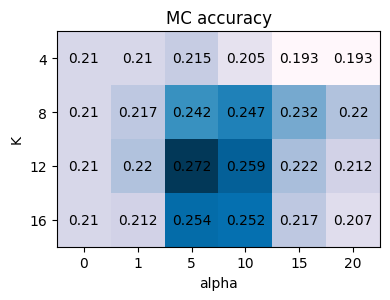

In [40]:
import numpy as np

ks = [4, 8, 12, 16] # sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))
alphas = [0, 1, 5, 10, 15, 20] # sorted(list(set([a for k, a in accs_by_k_alpha.keys()])))

a = np.zeros((len(ks), len(alphas)))
for k_i, k in enumerate(ks):
    for a_i, alpha in enumerate(alphas):
        a[k_i, a_i] = f"{np.mean(accs_by_k_alpha[(k, alpha)]).item():.3f}"


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((4, 4))
im = ax.imshow(a, cmap="PuBu")

ax.set_xticks(np.arange(len(alphas)), labels=alphas)
ax.set_yticks(np.arange(len(ks)), labels=ks)

for i in range(len(ks)):
    for j in range(len(alphas)):
        text = ax.text(j, i, a[i, j],
                       ha="center", va="center", color="black")

ax.set_title("MC accuracy")
ax.set_xlabel("alpha")
ax.set_ylabel("K")
fig.tight_layout()
plt.savefig("images/MC_acc_steering_gemma.png")

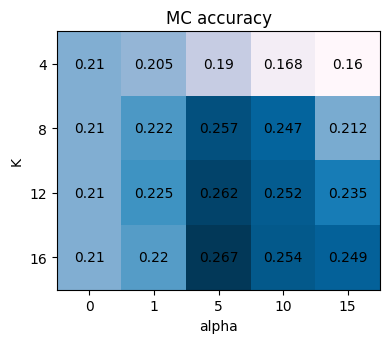

In [53]:
import numpy as np
import torch
with open("cache/accs_by_k_alpha_gemma_on_probing_dataset.json", "r") as file:
    accs_by_k_alpha_json = json.load(file)
accs_by_k_alpha = {}
for k, v in accs_by_k_alpha_json.items():
    accs_by_k_alpha[eval(k)] = eval(v)

ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))

with open("cache/accs_by_k_alpha_gemma_full_layer_on_probing_dataset_no_intervention.json", "r") as file:
    accs_no_intervention_json = json.load(file)
for k in ks:
    accs_by_k_alpha[(k, 0)] = eval(accs_no_intervention_json.replace("tensor", ""))

# ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))
alphas = sorted(list(set([a for k, a in accs_by_k_alpha.keys()])))

a = np.zeros((len(ks), len(alphas)))
for k_i, k in enumerate(ks):
    for a_i, alpha in enumerate(alphas):
        a[k_i, a_i] = f"{np.mean(accs_by_k_alpha[(k, alpha)]).item():.3f}"


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((4, 4))
im = ax.imshow(a, cmap="PuBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(alphas)), labels=alphas)
ax.set_yticks(np.arange(len(ks)), labels=ks)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ks)):
    for j in range(len(alphas)):
        text = ax.text(j, i, a[i, j],
                       ha="center", va="center", color="black")

ax.set_title("MC accuracy")
ax.set_xlabel("alpha")
ax.set_ylabel("K")
fig.tight_layout()
# plt.show()
plt.savefig("images/MC_acc_steering_gemma.png")

In [ ]:
test: 16 5 0.2696078431372549 -2.2552245013854084